
# Tremor Analysis Using IMU Sensor Data

This notebook analyzes emulated tremor data recorded via an IMU sensor on the **right wrist** during various frequency conditions and during voluntrary movements. Our goal is to extract tremor characteristics such as amplitude and frequency over time.

## Data Collection

We recorded IMU data using a [device/model] placed on the right wrist. The dataset includes:
- **Emulated tremor** across a range of frequencies (e.g., 3 Hz, 5 Hz, 7 Hz)
- **Different movements**, such as:
  - Static posture
  - Voluntary wrist flexion/extension
  - Circular or multi-joint movements

The recordings were sampled at [sampling rate] Hz, and include acceleration and/or gyroscopic data along 3 axes (x, y, z).

## Data Structure and Loading

The IMU data is stored in `.h5` format and contains recordings from multiple sensors. We begin by listing all available IMU devices, selecting one (e.g., `imus[6]`), and loading:

- **Accelerometer**: 3-axis acceleration (m/s²)
- **Gyroscope**: 3-axis angular velocity (°/s)
- **Orientation**: 3-axis orientation estimate (degrees)
- **Timestamp**: Corresponding time values (seconds)

In [165]:
from load_data import *

In [166]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/3Hz_trial2/IMU.h5'
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial2/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[6])
    print(f"Keys in {imus[6]}:", keys)

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BFD802900B5: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


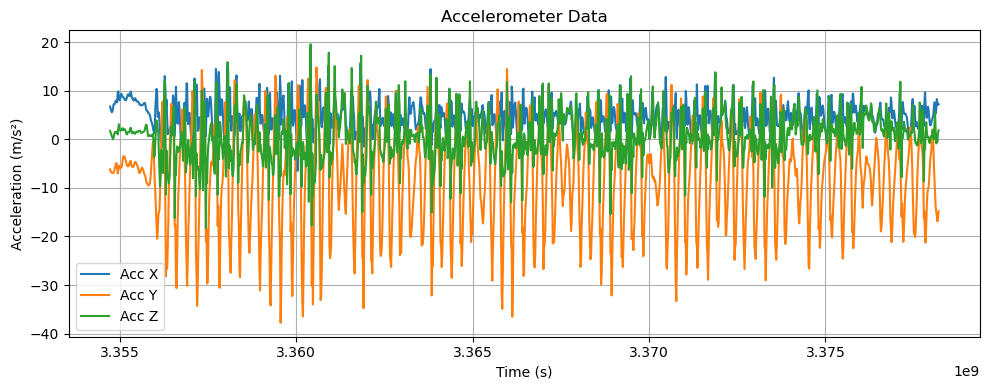

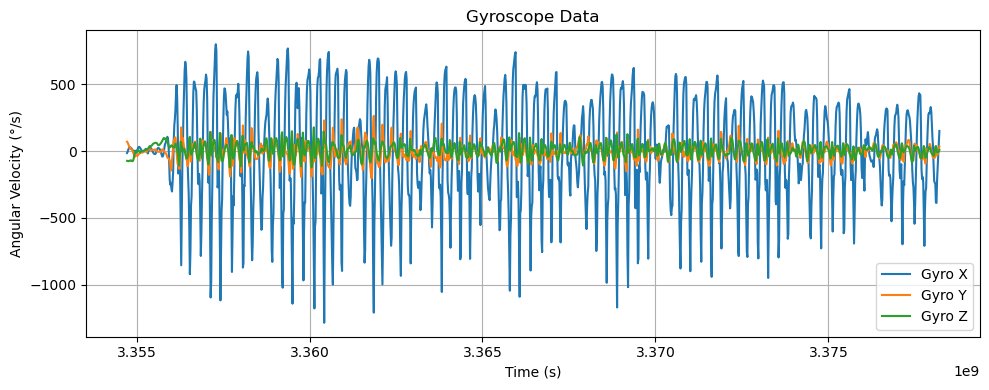

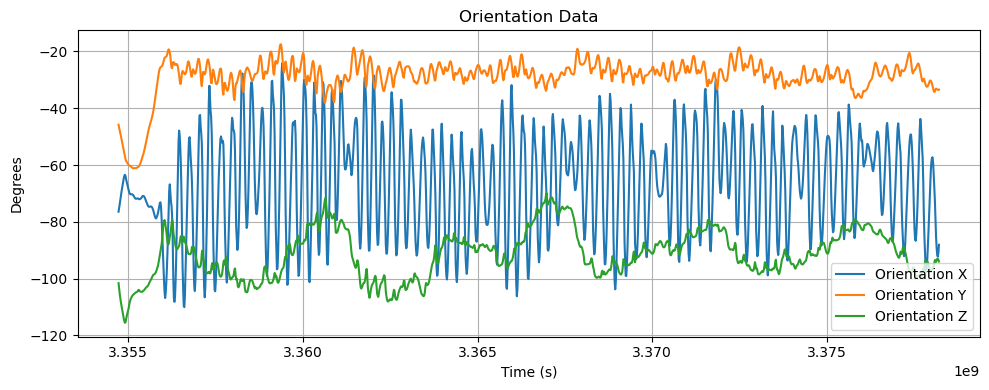

In [167]:
acc, gyro, orient, time = load_imu_data(path, imus[6])
plot_imu_data(acc, gyro, orient, time)

## Preprocessing the IMU Signal

Before analyzing tremor dynamics, we preprocess the raw accelerometer data to ensure clean and interpretable signals. The preprocessing steps include:

- **Detrending**: Removes any slow linear drift in the signal, which could distort frequency analysis.
- **Centering**: Subtracts the mean from the signal to center it around zero, allowing clearer spectral peaks.

These steps help suppress low-frequency artifacts and enhance the visibility of tremor-related frequencies in the subsequent analysis.

## Frequency Analysis using FFT and Harmonics

We analyze the frequency content of the wrist tremor using the **Fast Fourier Transform (FFT)**:

- The FFT transforms the time-domain acceleration signal into the frequency domain.
- We visualize the magnitude spectrum to identify the **dominant frequency**, which typically corresponds to the tremor frequency.

### Harmonics in Tremor Signals

Tremor signals are often not purely sinusoidal—they can contain **higher-frequency components** known as *harmonics*, especially if the tremor has a non-sinusoidal (e.g., sawtooth-like or jagged) shape. For example, a tremor oscillating at 3 Hz may exhibit additional peaks at 6 Hz, 9 Hz, etc.

We therefore:
- Detect the **fundamental tremor frequency** (largest peak, ignoring DC)
- Highlight up to 3 harmonic frequencies to capture the full spectral structure

This analysis helps characterize the **regularity, shape, and richness** of the tremor waveform beyond just the base frequency.

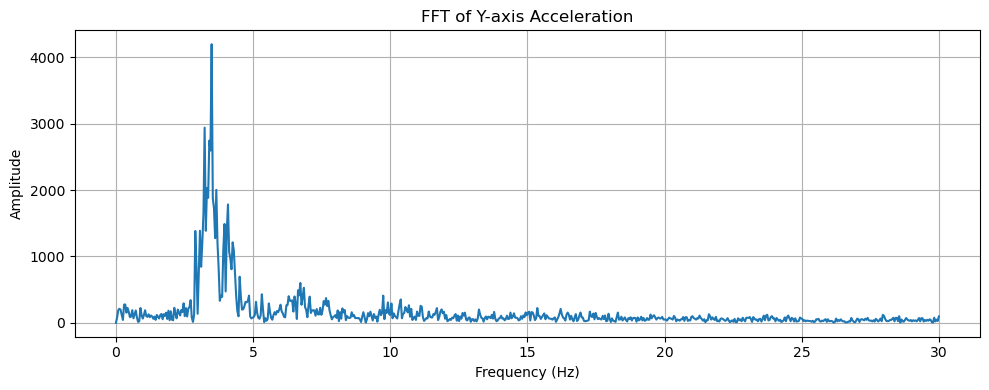

In [168]:
y_axis_signal = acc[1]
signal_clean = preprocess_signal(y_axis_signal)
freqs, fft_vals = compute_fft(signal_clean, fs=60)
plot_fft(freqs, fft_vals, title="FFT of Y-axis Acceleration")

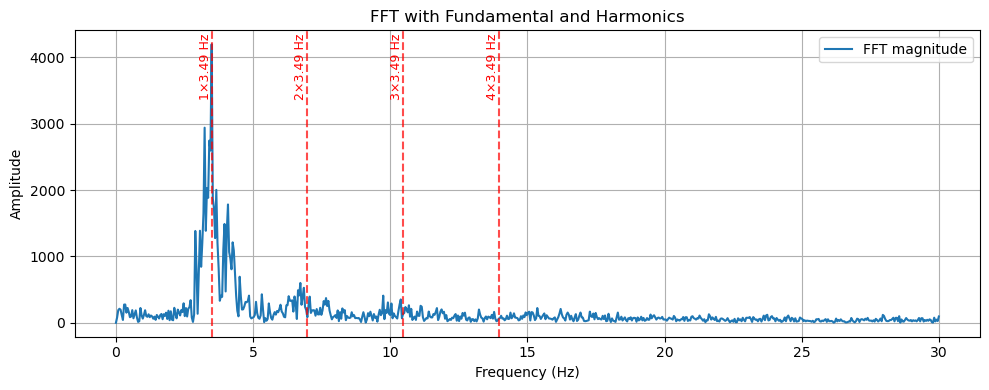

Fundamental frequency: 3.49 Hz


In [169]:
# Example using Y-axis accelerometer data
fund_freq = analyze_fft_with_harmonics(acc[1], fs=60, n_harmonics=4)
print(f"Fundamental frequency: {fund_freq:.2f} Hz")

## Transforming IMU Data into the World Frame and Analyzing Tremor with Wavelets

To better understand the tremor dynamics, we first **transform the accelerometer data from the device frame into the world frame** using orientation information:

- The IMU provides orientation as **Euler angles** (roll, pitch, yaw), which we convert to **rotation matrices**.
- We then **rotate the 3D acceleration vectors** accordingly, aligning them with a consistent external (world) coordinate system.
- After transformation, we **subtract gravity** (approximated as [0, 0, 9.81] m/s²), isolating true movement-induced acceleration.

### Continuous Wavelet Transform (CWT) Spectrogram

After isolating the tremor signal along the most relevant axis (e.g., Y-axis), we apply a **Continuous Wavelet Transform (CWT)**:

- The CWT allows **time–frequency analysis**, capturing how the tremor frequency evolves over time.
- Unlike FFT, which gives a global frequency snapshot, CWT shows **when** specific frequency components are active.

### Why This Plot Matters

- The spectrogram highlights **bursts or shifts** in tremor frequency during different phases of movement.
- It reveals whether tremor is stable or **modulated over time**, which is crucial for characterizing real vs. emulated tremor, assessing intervention effects, or developing control algorithms.

The resulting plot shows:
- Time on the x-axis
- Frequency on the y-axis (up to 10 Hz)
- Color intensity representing signal amplitude at each frequency and time point

## Converting Wavelet Scales to Frequencies in the CWT Spectrogram

When analyzing tremor signals using the Continuous Wavelet Transform (CWT), the raw output is computed over a range of **scales** — abstract units that relate to frequency, but are not directly interpretable.

To make the spectrogram meaningful in terms of real-world time and frequency, we **convert these wavelet scales to actual frequency values in Hz** using the known relationship for the Morlet wavelet:

\[
f \approx \frac{f_s}{w \cdot \text{scale}}
\]

Where:
- \( f \) is the frequency in Hz,
- \( f_s \) is the sampling frequency (e.g., 60 Hz),
- \( w \) is the wavelet width (controls frequency resolution),
- and `scale` is the wavelet scale index.

This transformation allows us to:
- Interpret the **vertical axis of the spectrogram as real frequency** (Hz),
- Analyze how tremor **frequency content evolves over time**, and
- Easily identify **dominant tremor bands** (e.g., 3–6 Hz) and their changes.

By plotting the spectrogram with this conversion, we gain a clearer and more interpretable view of the tremor's dynamics across time.

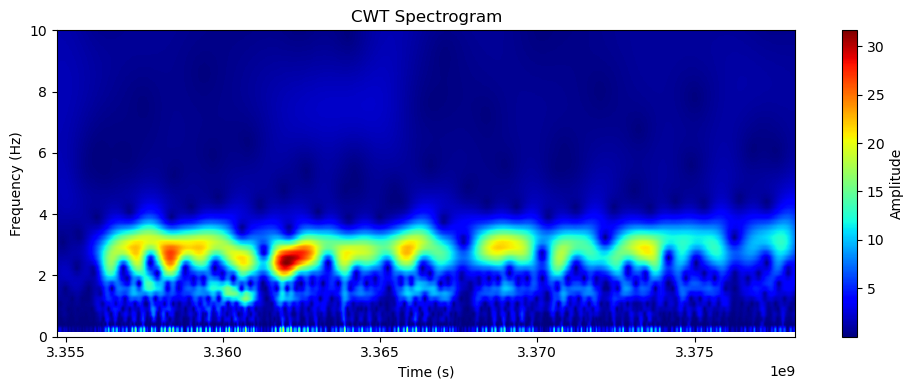

In [170]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Assume you already loaded these from your HDF5:
# acc: shape (3, N)
# orient: shape (3, N)

# Transpose to shape (N, 3)
acc = acc.T
orient = orient.T

# Compute rotation matrices from orientation (Euler angles in degrees)
rot = R.from_euler('xyz', orient, degrees=True)

# Rotate acceleration into world frame
acc_world = rot.apply(acc)

# Subtract gravity (assuming gravity vector is [0, 0, 9.81])
acc_world -= np.array([0, 0, 9.81])
# Choose one axis (e.g., Y-axis of tremor_band or acc_world)
signal = acc_world[:, 1]  # Y-axis
signal = signal - np.mean(signal)  # Remove DC offset if needed

cwt_matrix, freqs = analyze_cwt_spectrogram(signal, time, fs=60, max_freq=10)

Observed Low-Frequency Peaks in CWT but Not in FFT

In the Continuous Wavelet Transform (CWT) spectrogram of our tremor signal, we observe peaks at low frequencies, often below the expected tremor frequency (e.g., < 3 Hz). Interestingly, these low-frequency components do not appear in the FFT spectrum of the same signal.

This discrepancy suggests that the low-frequency energy seen in the CWT is not due to a true oscillatory component, but may instead result from:
	•	Amplitude modulation
Tremor may vary in intensity over time (e.g., in bursts), creating slow envelope fluctuations that appear as low-frequency components in time–frequency analyses.
	•	Transient behavior or onset/offset effects
Sudden changes at the beginning or end of the recording can introduce low-frequency energy in CWT due to its sensitivity to short-lived events.
	•	Residual drift or baseline shifts
Incomplete removal of gravity or slow drift in the accelerometer signal can produce low-frequency trends that the CWT captures more readily than the FFT.
	•	Wavelet time–frequency tradeoff
The Morlet wavelet used in CWT has limited frequency resolution. Strong power at a given frequency can “bleed” into neighboring frequencies, especially in the lower spectrum.

⸻

Cross-Validation with FFT

Since the FFT shows no significant peaks at these low frequencies, we conclude that the low-frequency power observed in the CWT is likely an artifact of:
	•	Amplitude envelope dynamics
	•	Short-term transient behavior
	•	Resolution limitations of the wavelet transform

Thus, the dominant oscillation remains centered in the expected tremor band (e.g., around 3 Hz), and there is no evidence of a true low-frequency tremor.

We see these low-frequency peaks in the CWT, but not in the FFT, reinforcing that they are likely due to non-oscillatory signal features.
Additionally, harmonics are clearly visible in the FFT spectrum, but not in the CWT spectrogram. This is likely due to the limited frequency resolution of the wavelet transform and the time–frequency tradeoff inherent to CWT, which makes it less sensitive to sharp spectral peaks like harmonics.

Based on the combined insights from the FFT and CWT analyses, we apply a bandpass filter with cutoff frequencies at 2 Hz and 4 Hz to isolate the tremor component for our further analysis.

Tremor Direction Estimation and Hilbert Analysis

To further characterize the tremor, we first isolate its frequency band and analyze its direction and temporal dynamics using the following steps:

1. Bandpass Filtering

We apply a bandpass filter to the 3-axis acceleration signal (in the world frame) with a passband of 2–4 Hz. This isolates the dominant tremor frequency while suppressing slower movements and high-frequency noise. The resulting signal is referred to as the tremor band.

2. Estimating Tremor Direction via PCA

We apply Principal Component Analysis (PCA) over short sliding windows to estimate the dominant direction of tremor over time. PCA identifies the axis along which the tremor oscillation has the most variance. The resulting 3D direction vectors (X, Y, Z components) describe the orientation of the tremor movement as it evolves.
	•	The plot shows how the X, Y, and Z components of the dominant tremor direction vary over time.
	•	This helps us assess whether the tremor is directionally stable (e.g., always aligned with one axis) or fluctuates during the recording.

3. Hilbert Transform for Envelope and Phase

We apply the Hilbert transform to the filtered tremor band to extract:
	•	The envelope, representing the instantaneous tremor amplitude (how strong the tremor is at each moment).

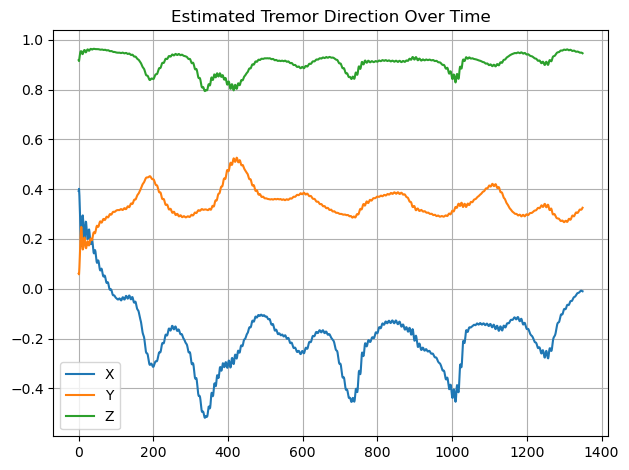

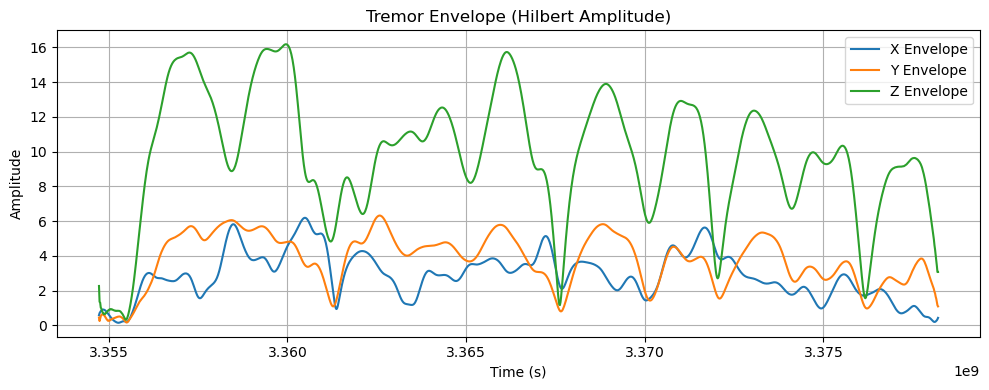

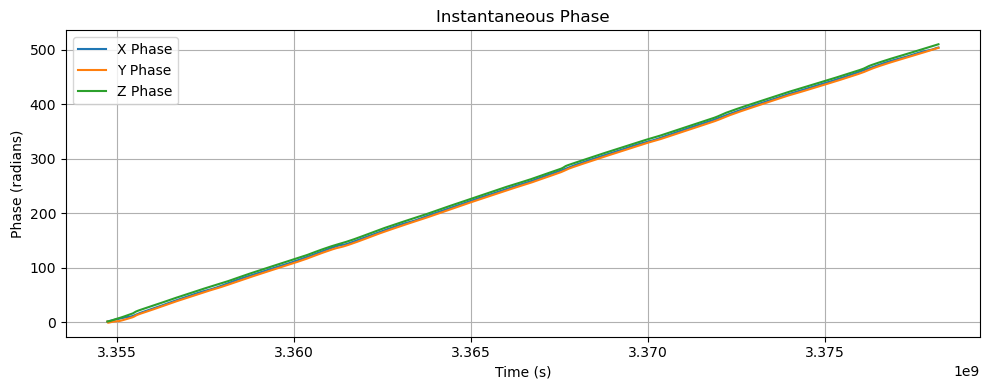

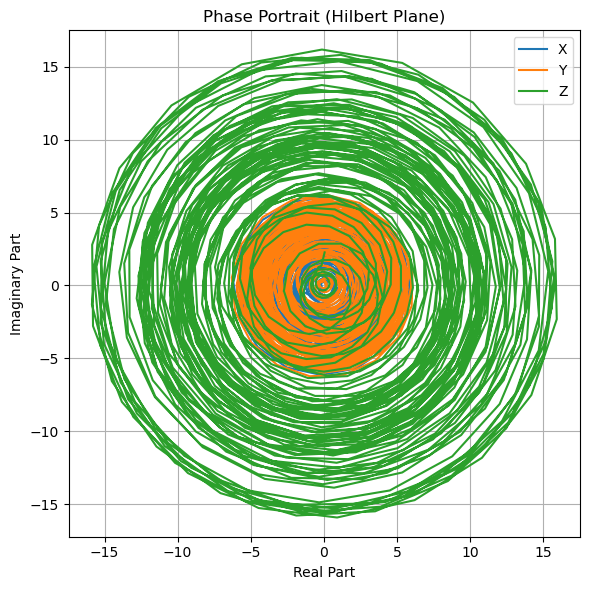

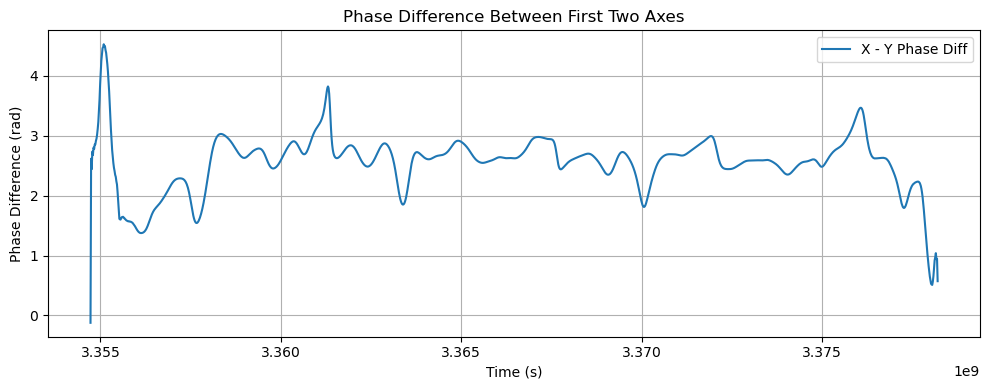

In [171]:
# Step 1: Filter the raw acceleration to get tremor band
tremor_band = bandpass_filter(acc_world, lowcut=2, highcut=4, fs=60)

# Step 2: Estimate tremor direction (dominant axis over time)
tremor_dir_vectors = estimate_tremor_direction_pca(tremor_band, fs=60)

# Step 3: Plot tremor direction over time
import matplotlib.pyplot as plt
plt.plot(tremor_dir_vectors[:, 0], label='X')
plt.plot(tremor_dir_vectors[:, 1], label='Y')
plt.plot(tremor_dir_vectors[:, 2], label='Z')
plt.title("Estimated Tremor Direction Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Apply Hilbert transform and analyze envelope & phase (on filtered tremor_band!)
envelope, phase, analytic_signal = analyze_tremor_hilbert(
    tremor_band,
    time[:tremor_band.shape[0]],  # time array must match length
    axis_labels=['X', 'Y', 'Z']
)

Both the PCA-based direction estimation and the Hilbert envelope analysis indicate that the tremor exhibits maximum amplitude along the Z-axis. Specifically, the direction of greatest variance identified by PCA aligns with the Z-axis, which also shows the strongest amplitude in the Hilbert envelope.

This consistent result across two independent methods strongly suggests that the tremor is primarily occurring along the Z-axis

### Loading and Visualizing IMU Data for Tremor Frequency Switch

In this section, we load a new IMU dataset recorded during a trial where the **tremor frequency changes mid-trial** — beginning at 2 Hz and transitioning to 4 Hz.

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BFD802900B5: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


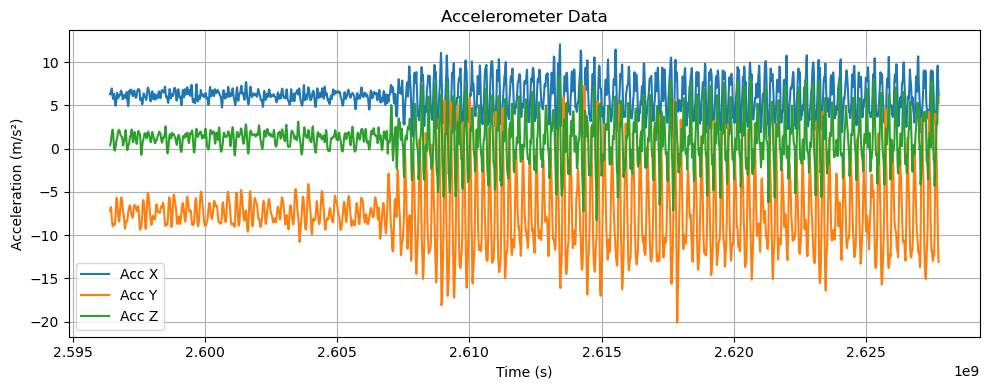

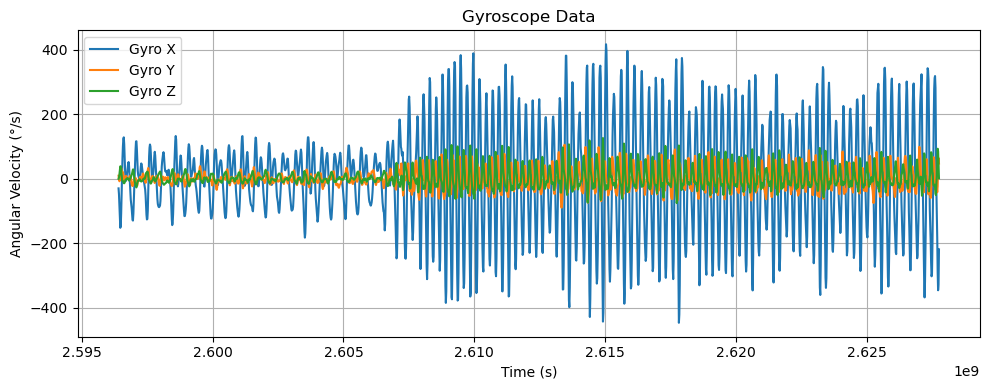

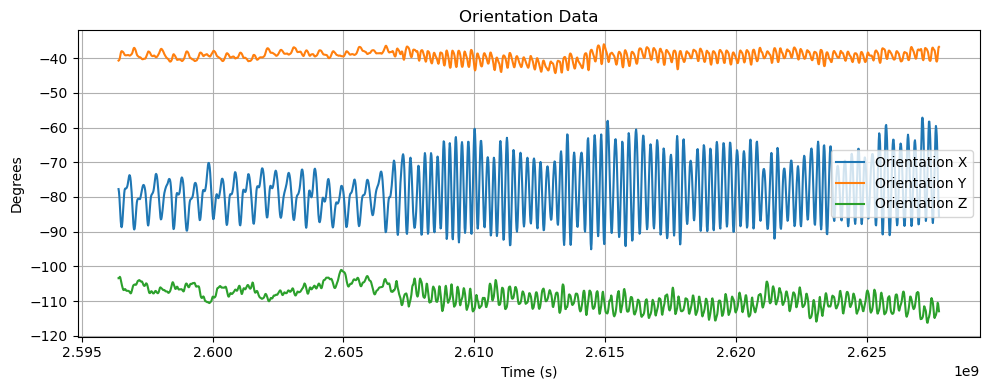

In [172]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/2Hz_4Hz_trial1/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[6])
    print(f"Keys in {imus[6]}:", keys)

acc, gyro, orient, time = load_imu_data(path, imus[6])
plot_imu_data(acc, gyro, orient, time)

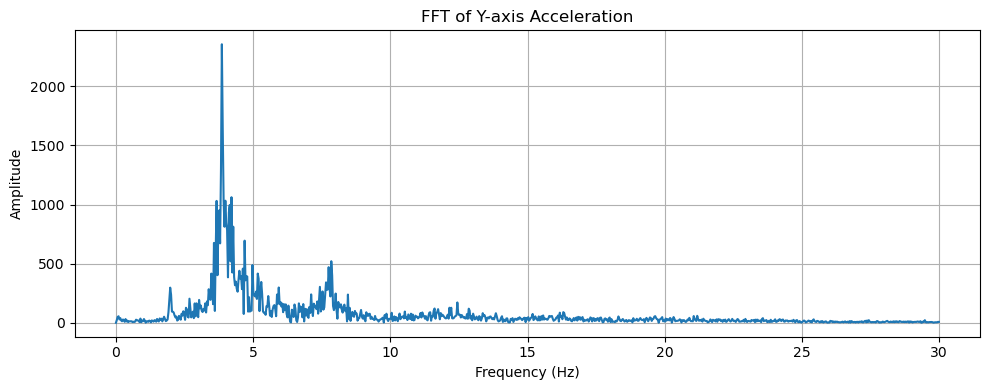

In [173]:
y_axis_signal = acc[1]
signal_clean = preprocess_signal(y_axis_signal)
freqs, fft_vals = compute_fft(signal_clean, fs=60)
plot_fft(freqs, fft_vals, title="FFT of Y-axis Acceleration")

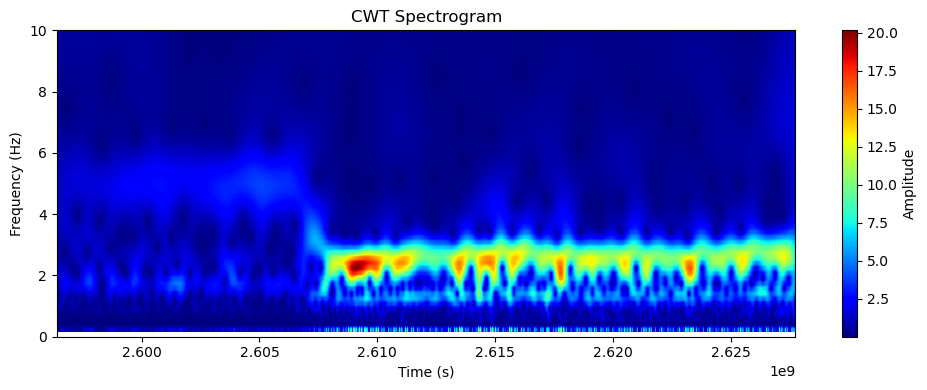

In [174]:
from scipy.spatial.transform import Rotation as R
import numpy as np



# Compute rotation matrices from orientation (Euler angles in degrees)
rot = R.from_euler('xyz', orient.T, degrees=True)

# Rotate acceleration into world frame
acc_world = rot.apply(acc.T)

# Subtract gravity (assuming gravity vector is [0, 0, 9.81])
acc_world -= np.array([0, 0, 9.81])
# Choose one axis (e.g., Y-axis of tremor_band or acc_world)
signal = acc_world[:, 1]  # Y-axis
signal = signal - np.mean(signal)  # Remove DC offset if needed

_, _ = analyze_cwt_spectrogram(signal, time, fs=60, max_freq=10)

In [175]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import butter, filtfilt

# # --- 1. Preprocessing function ---
# def preprocess_signal(signal, fs, lowcut=1.0, highcut=10.0):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(3, [low, high], btype='band')
#     return filtfilt(b, a, signal)

# # --- 2. Updated Kalman filter bank ---
# def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1,
#                                    power_bias=1.5, process_noise_bias=1.5):
#     N = len(signal)
#     dt = 1 / fs
#     spec = np.zeros((len(freqs), N))
#     uncertainty = np.zeros((len(freqs), N))

#     for i, f in enumerate(freqs):
#         omega = 2 * np.pi * f
#         x = np.zeros(2)
#         P = np.eye(2)
#         Q = (q / (f**process_noise_bias)) * np.eye(2)
#         R = r

#         for k in range(N):
#             H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
#             y = signal[k]

#             x_pred = x
#             P_pred = P + Q

#             S = H @ P_pred @ H.T + R
#             K = P_pred @ H.T / S
#             x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
#             P = (np.eye(2) - K @ H) @ P_pred

#             power = np.sum(x ** 2) / (f**power_bias)
#             spec[i, k] = power
#             uncertainty[i, k] = np.trace(P)  # total state uncertainty

#     return spec, uncertainty


# # --- 3. Harmonic-based fundamental frequency detection ---
# def harmonic_score_column(spec_col, freqs, max_harmonics=4, threshold=0.5):
#     scores = []
#     f_max = freqs[-1]

#     for i, f in enumerate(freqs):
#         harmonics = []
#         for h in range(1, max_harmonics + 1):
#             f_h = f * h
#             if f_h > f_max:
#                 continue
#             idx = np.argmin(np.abs(freqs - f_h))
#             if idx < len(spec_col) and spec_col[idx] > threshold:
#                 harmonics.append(spec_col[idx] / h**2)
#         scores.append(np.sum(harmonics) if harmonics else 0.0)

#     return scores

# def extract_fundamental_from_spec(spec, freqs, fs, max_harmonics=4, threshold=0.5):
#     fundamental_freqs = []
#     for k in range(spec.shape[1]):
#         spec_col = spec[:, k]
#         scores = harmonic_score_column(spec_col, freqs, max_harmonics=max_harmonics, threshold=threshold)
#         best_idx = np.argmax(scores)
#         fundamental_freqs.append(freqs[best_idx])
#     return np.array(fundamental_freqs)

# # --- 4. Plotting ---
# def plot_kalman_spectrogram_with_fundamental(spec, freqs, fs, fundamental_freqs, title='Kalman Spectrogram with Fundamental'):
#     t = np.arange(spec.shape[1]) / fs
#     spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

#     plt.figure(figsize=(12, 5))
#     plt.imshow(spec_db, extent=[t[0], t[-1], freqs[0], freqs[-1]],
#                aspect='auto', origin='lower', cmap='viridis')
#     plt.plot(t, fundamental_freqs, color='red', linewidth=2, label='Fundamental (Harmonic Scoring)')
#     #plot freq qith max power at that timepoint
#     max_power_indices = np.argmax(spec, axis=0)
#     max_power_freqs = freqs[max_power_indices]
#     plt.plot(t, max_power_freqs, color='blue', linewidth=2, label='Max Power Frequency')
#     #smoothed max power over time
#     smoothed_max_power_freqs = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')
#     plt.plot(t, smoothed_max_power_freqs, color='green', linewidth=2, label='Smoothed Max Power Frequency')

#     ground_truth_freqs = np.ones(len(t))*2  # Example ground truth frequencies
#     ground_truth_freqs[670:] = ground_truth_freqs[670:]*2.0  # First 650 samples at 2 Hz
#     ground_truth_freqs[670] = np.nan
#     plt.plot(t, ground_truth_freqs, color='black', linestyle='--', label='Ground Truth Frequency')
    
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.title(title)
#     plt.colorbar(label='Normalized Power (dB)')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
# fs = 60  # Sampling frequency
# preprocessed = preprocess_signal(acc[1], fs)  # Preprocess Y-axis accelerometer data
# freq_grid = np.linspace(1, 10, 100)  # 1–10 Hz, 100 bins
# spec, uncertainty = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid, power_bias=1.5, process_noise_bias=1.5)

# fundamental_freqs = extract_fundamental_from_spec(spec, freq_grid, fs, max_harmonics=4, threshold=0.5)
# plot_kalman_spectrogram_with_fundamental(spec, freq_grid, fs, fundamental_freqs, title='Kalman Spectrogram with Fundamental Frequency')
# #spec, uncertainty = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid)

# # max_power_indices = np.argmax(spec, axis=0)
# # uncertainty_trace = uncertainty[max_power_indices, np.arange(spec.shape[1])]
# # t = np.arange(spec.shape[1]) / fs
# # max_freqs = freq_grid[max_power_indices]



# # plt.figure(figsize=(12, 4))
# # plt.plot(t[10:], uncertainty_trace[10:], 'r-', label='Max Power Frequency')

# # plt.xlabel('Time (s)')
# # plt.ylabel('Frequency (Hz)')
# # plt.legend()
# # plt.title('Frequency Estimate with Kalman Uncertainty')
# # plt.tight_layout()
# # plt.grid(True)
# # plt.show()


# # def compute_frequency_uncertainty(spec, freqs):
# #     """
# #     Compute frequency uncertainty as the power-weighted standard deviation
# #     for each timepoint.
# #     """
# #     spec_sum = np.sum(spec, axis=0, keepdims=True) + 1e-10  # normalize to avoid divide-by-zero
# #     weights = spec / spec_sum
# #     mean_freqs = np.sum(weights * freqs[:, None], axis=0)
# #     var_freqs = np.sum(weights * (freqs[:, None] - mean_freqs[None, :])**2, axis=0)
# #     stddev_freqs = np.sqrt(var_freqs)
# #     return mean_freqs, stddev_freqs

# # def plot_with_uncertainty(t, fundamental_freqs, mean_freqs, stddev_freqs, ground_truth=None):
# #     """
# #     Plot estimated frequencies with uncertainty bands.
# #     """
# #     plt.figure(figsize=(12, 4))
# #     plt.plot(t, fundamental_freqs, 'r-', label='Fundamental Estimate')
# #     plt.plot(t, mean_freqs, 'b--', label='Power-Weighted Mean Frequency')
# #     plt.fill_between(t, mean_freqs - stddev_freqs, mean_freqs + stddev_freqs,
# #                      color='blue', alpha=0.3, label='Uncertainty (±1σ)')
# #     if ground_truth is not None:
# #         plt.plot(t, ground_truth, 'k-', linewidth=2, label='Ground Truth')
# #     plt.xlabel('Time (s)')
# #     plt.ylabel('Frequency (Hz)')
# #     plt.title('Fundamental Frequency with Uncertainty')
# #     plt.legend()
# #     plt.tight_layout()
# #     plt.grid(True)
# #     plt.show()


# # t = np.arange(spec.shape[1]) / fs
# # mean_freqs, stddev_freqs = compute_frequency_uncertainty(spec, freq_grid)

# # # Optional: generate ground truth (e.g., 2 Hz for 0–10s, 4 Hz after)
# # ground_truth = np.ones_like(t) * 2
# # ground_truth[int(len(t)//2):] = 4

# # plot_with_uncertainty(t, fundamental_freqs, mean_freqs, stddev_freqs, ground_truth)



In [176]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.colors import Normalize

# def generate_dual_panel_kalman_gif(signal, spec, freqs, fundamental_freqs,
#                                    fs=60, gif_path="kalman_dual_panel.gif", interval_ms=30, dpi=100):
#     """
#     Create a dual-panel GIF showing:
#     - Top: time-domain signal
#     - Bottom: frequency spectrogram with smoothed fundamental frequency
#     """
#     T = len(signal)
#     time = np.arange(T) / fs
#     norm_spec = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
#     fig.subplots_adjust(hspace=0.3)

#     # === Top: signal ===
#     ax1.set_title("Accelerometer Signal")
#     ax1.set_ylabel("Amplitude")
#     ax1.set_xlim(time[0], time[-1])
#     ax1.set_ylim(np.min(signal)*1.1, np.max(signal)*1.1)
#     signal_line, = ax1.plot([], [], lw=2)

#     # === Bottom: spectrogram ===
#     ax2.set_title("Kalman Filter Spectrogram with estimated Fundamental Frequency")
#     ax2.set_xlabel("Time (s)")
#     ax2.set_ylabel("Frequency (Hz)")
#     ax2.set_xlim(time[0], time[-1])
#     ax2.set_ylim(freqs[0], freqs[-1])

#     # Create an image for the spectrogram that will be updated per frame
#     spec_img = ax2.imshow(norm_spec[:, :1], extent=[time[0], time[1], freqs[0], freqs[-1]],
#                           aspect='auto', origin='lower', cmap='viridis', animated=True)

#     # Smoothed fundamental frequency line
#     smoothed_freqs = np.convolve(fundamental_freqs, np.ones(5)/5, mode='same')
#     fundamental_line, = ax2.plot([], [], 'r-', lw=2, label='Smoothed Fundamental')
#     ax2.legend(loc='upper right')

#     def init():
#         signal_line.set_data([], [])
#         fundamental_line.set_data([], [])
#         return signal_line, spec_img, fundamental_line

#     def update(frame):
#         # Update signal
#         signal_line.set_data(time[:frame], signal[:frame])

#         # Update spectrogram image
#         current_spec = norm_spec[:, :frame] if frame > 1 else norm_spec[:, :2]
#         spec_img.set_array(current_spec)
#         spec_img.set_extent([time[0], time[frame-1] if frame > 1 else time[1], freqs[0], freqs[-1]])

#         # Update fundamental line
#         fundamental_line.set_data(time[:frame], smoothed_freqs[:frame])

#         return signal_line, spec_img, fundamental_line

#     ani = animation.FuncAnimation(
#         fig, update, frames=T, init_func=init, blit=True,
#         interval=interval_ms, repeat=False
#     )

#     ani.save(gif_path, writer='pillow', dpi=60)
#     plt.close(fig)
#     print(f"GIF saved to: {gif_path}")


# generate_dual_panel_kalman_gif(
#     signal=preprocessed,
#     spec=spec,
#     freqs=freq_grid,
#     fundamental_freqs=smoothed_max_freqs,
#     fs=fs,
#     gif_path="kalman_dual_panel.gif"
# )

### Kalman Filter Bank for Tremor Frequency Tracking and Harmonic Scoring

This section implements a **Kalman filter bank spectrogram** to estimate tremor frequency over time with high temporal resolution. Unlike FFT or CWT, this approach tracks power in narrowband sinusoids using adaptive estimation, making it especially useful for **nonstationary signals** like tremor with possible frequency changes.

#### Key Steps:

1. **Bandpass Preprocessing**  
   The raw tremor signal is first filtered between 1–10 Hz to isolate physiologically plausible tremor components.

2. **Kalman Filter Bank Spectrogram**  
   A set of Kalman filters—each tuned to a different frequency—is used to track the power at that frequency over time. For each frequency bin:
   - The signal is projected onto sinusoids at that frequency.
   - A 2D Kalman filter estimates the sinusoid amplitude.
   - Power is estimated from the amplitude squared.
   - The output is a high-resolution time–frequency matrix `spec`.

3. **Harmonic Scoring**  
   For each time point, the algorithm scores frequencies not just by raw power but by the presence of their **harmonics** (e.g., 2×, 3× the base frequency). This helps identify the **true fundamental tremor frequency**, which may not always have the strongest peak but exhibits harmonic structure.

4. **Uncertainty Quantification**  
   A power-weighted mean and standard deviation of the frequency are computed to give a **confidence band** around the estimated frequency.

5. **Visualization**  
   Three plots are produced:
   - A spectrogram over time with overlays for:
     - the fundamental frequency (from harmonic scoring),
     - max-power frequency,
     - smoothed peak track.
   - A harmonic score trace over time.
   - A frequency vs. time plot with uncertainty bands.

#### Why Use This?
This approach is ideal for:
- **Tracking frequency changes over time**, such as transitions from 2 Hz to 4 Hz tremor.
- **Robustly identifying the true tremor frequency** based on harmonic structure, not just raw power.
- **Visualizing tremor characteristics** with both interpretability and precision.

It complements FFT and CWT by providing adaptive tracking with both high temporal resolution and harmonic specificity.

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


def preprocess_signal(signal, fs, lowcut=1.0, highcut=10.0):
    """Bandpass filter the input signal between lowcut and highcut Hz."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, [low, high], btype='band')
    return filtfilt(b, a, signal)


def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1,
                                   power_bias=1.5, process_noise_bias=1.5):
    """Estimate time-frequency power via a Kalman filter bank."""
    N = len(signal)
    dt = 1 / fs
    spec = np.zeros((len(freqs), N))
    uncertainty = np.zeros((len(freqs), N))

    for i, f in enumerate(freqs):
        omega = 2 * np.pi * f
        x = np.zeros(2)
        P = np.eye(2)
        Q = (q / (f**process_noise_bias)) * np.eye(2)
        R = r

        for k in range(N):
            H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y = signal[k]

            x_pred = x
            P_pred = P + Q

            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T / S
            x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
            P = (np.eye(2) - K @ H) @ P_pred

            power = np.sum(x ** 2) / (f**power_bias)
            spec[i, k] = power
            uncertainty[i, k] = np.trace(P)

    return spec, uncertainty


def harmonic_score_column(spec_col, freqs, max_harmonics=4, threshold=0.5):
    scores = []
    f_max = freqs[-1]
    for i, f in enumerate(freqs):
        harmonics = []
        for h in range(1, max_harmonics + 1):
            f_h = f * h
            if f_h > f_max:
                continue
            idx = np.argmin(np.abs(freqs - f_h))
            if idx < len(spec_col) and spec_col[idx] > threshold:
                harmonics.append(spec_col[idx] / h**2)
        scores.append(np.sum(harmonics) if harmonics else 0.0)
    return scores


def extract_fundamental_from_spec(spec, freqs, fs, max_harmonics=4, threshold=0.5):
    fundamental_freqs = []
    all_scores = []
    for k in range(spec.shape[1]):
        spec_col = spec[:, k]
        scores = harmonic_score_column(spec_col, freqs, max_harmonics=max_harmonics, threshold=threshold)
        best_idx = np.argmax(scores)
        fundamental_freqs.append(freqs[best_idx])
        all_scores.append(scores)
    return np.array(fundamental_freqs), np.array(all_scores)


def compute_frequency_uncertainty(spec, freqs):
    """Compute power-weighted mean and std deviation of frequency."""
    spec_sum = np.sum(spec, axis=0, keepdims=True) + 1e-10
    weights = spec / spec_sum
    mean_freqs = np.sum(weights * freqs[:, None], axis=0)
    var_freqs = np.sum(weights * (freqs[:, None] - mean_freqs[None, :])**2, axis=0)
    stddev_freqs = np.sqrt(var_freqs)
    return mean_freqs, stddev_freqs


def plot_all_kalman_analysis(signal, fs, freqs, spec, fundamental_freqs, harmonic_scores, uncertainty):
    t = np.arange(len(signal)) / fs
    max_power_indices = np.argmax(spec, axis=0)
    max_power_freqs = freqs[max_power_indices]
    smoothed_max_freqs = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')
    spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

    # 1. Spectrogram with overlays
    plt.figure(figsize=(12, 5))
    plt.imshow(spec_db, extent=[t[0], t[-1], freqs[0], freqs[-1]], aspect='auto', origin='lower', cmap='viridis')
    plt.plot(t, fundamental_freqs, 'r-', label='Fundamental (harmonic scoring)')
    plt.plot(t, max_power_freqs, 'b--', label='Max Power Frequency')
    plt.plot(t, smoothed_max_freqs, 'g-', label='Smoothed Max Frequency')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Kalman Spectrogram with Harmonic Scoring")
    plt.colorbar(label="Power (dB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Harmonic scores over time
    plt.figure(figsize=(12, 4))
    plt.plot(t, [np.max(score_row) for score_row in harmonic_scores], 'm-', label='Max Harmonic Score')
    plt.title("Harmonic Score Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Frequency estimate with uncertainty
    mean_freqs, stddev_freqs = compute_frequency_uncertainty(spec, freqs)
    plt.figure(figsize=(12, 4))
    plt.plot(t, fundamental_freqs, 'r-', label='Fundamental Estimate')
    plt.plot(t, mean_freqs, 'b--', label='Power-Weighted Mean Freq')
    plt.fill_between(t, mean_freqs - stddev_freqs, mean_freqs + stddev_freqs,
                     color='blue', alpha=0.3, label='Uncertainty (±1σ)')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Frequency Estimate with Uncertainty")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return smoothed_max_freqs


def run_kalman_tremor_analysis(signal, fs, freq_grid):
    signal_filt = preprocess_signal(signal, fs)
    spec, uncertainty = kalman_filter_bank_spectrogram(signal_filt, fs, freq_grid)
    fundamental_freqs, harmonic_scores = extract_fundamental_from_spec(spec, freq_grid, fs)
    smoothed_max_freqs = plot_all_kalman_analysis(signal_filt, fs, freq_grid, spec, fundamental_freqs, harmonic_scores, uncertainty)
    return spec, fundamental_freqs, harmonic_scores, uncertainty, smoothed_max_freqs

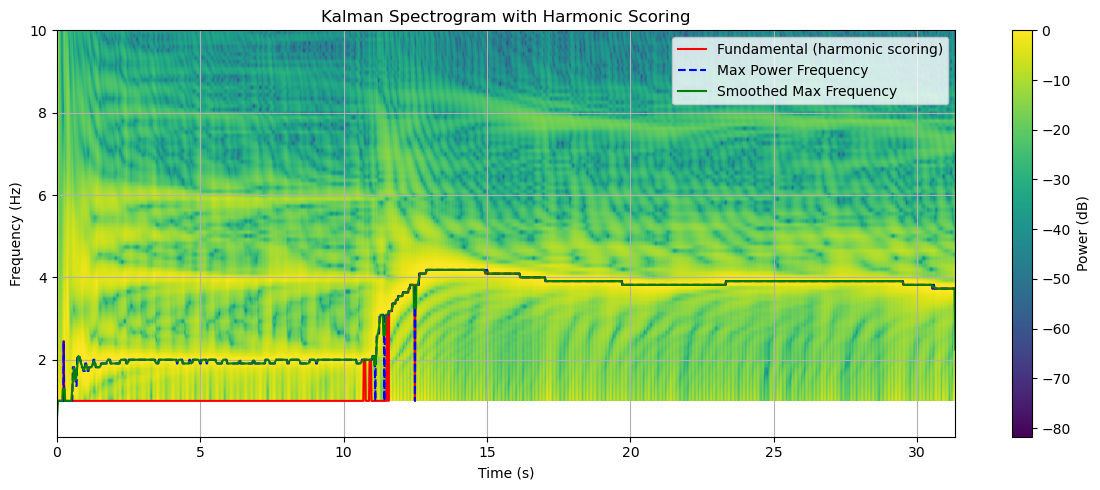

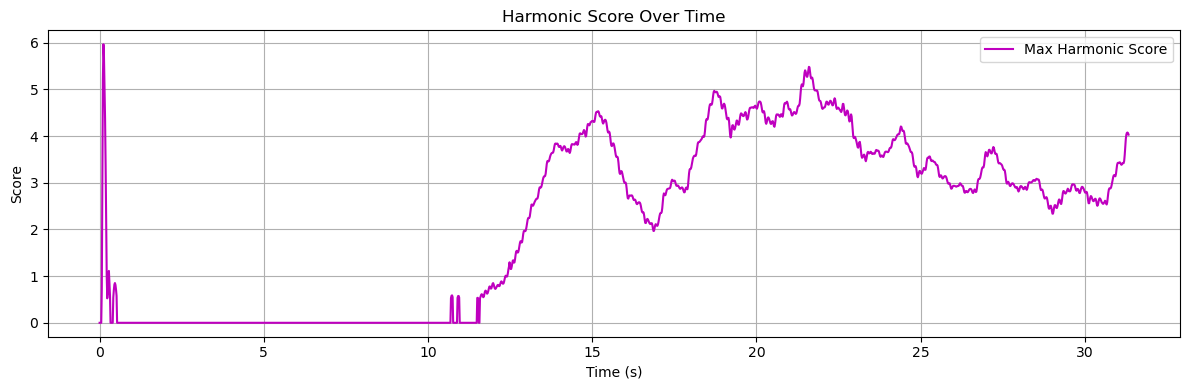

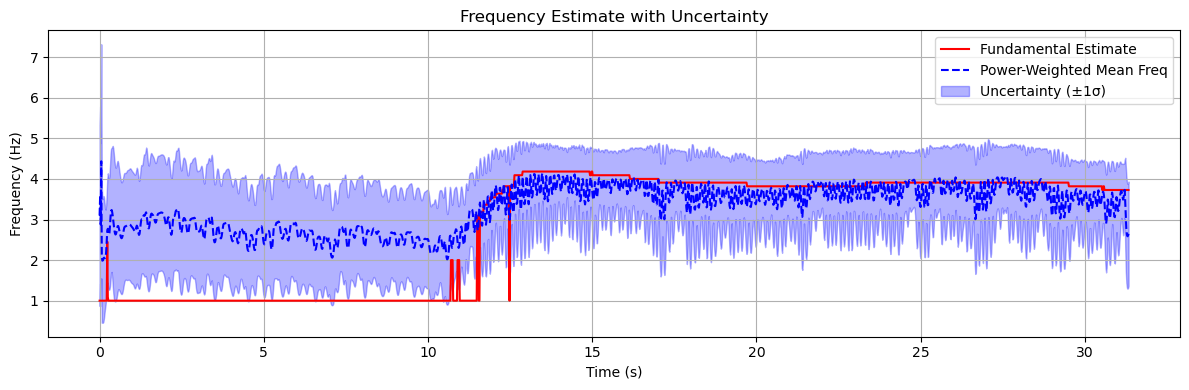

In [178]:
fs = 60
freq_grid = np.linspace(1, 10, 100)
signal = acc[1]  # e.g., Y-axis accelerometer

spec, fundamental_freqs, harmonic_scores, uncertainty,smoothed_max_freqs = run_kalman_tremor_analysis(signal, fs, freq_grid)

Harmonic Score and Frequency Tracking Over Time

To robustly identify the tremor frequency in time-varying signals, we analyze both the harmonic structure and the instantaneous frequency estimate using a Kalman filter bank.

Harmonic Score Over Time

The harmonic score quantifies how well a candidate base frequency explains the spectral content of the signal through its harmonics (integer multiples). For each time point:
	•	The algorithm checks whether multiples of a frequency (e.g., 2f, 3f, \ldots) contain significant energy.
	•	A higher score means that a fundamental frequency and its harmonics are strongly present in the signal.
	•	A lower score suggests either a pure sinusoid (with few or no harmonics), or a signal with weak or noisy harmonic content.

This score helps us identify meaningful tremor frequencies, especially in signals that are not purely sinusoidal.

Frequency Estimate with Uncertainty

We also plot the estimated tremor frequency over time using a Kalman filter-based spectrogram:
	•	The red line shows the fundamental frequency estimate based on harmonic scoring.
	•	The blue dashed line shows the power-weighted mean frequency at each time point.
	•	The shaded blue region indicates ±1 standard deviation—capturing the uncertainty of the frequency estimate.

This view allows us to evaluate how confident we are in the frequency estimate, and how consistent it is with harmonic structure in the signal.

Observations
	•	In the early part of the recording (around 2 Hz):
	•	The harmonic score is low, even though we observe multiple harmonics in the Kalman spectrogram.
	•	The estimated frequency exhibits higher uncertainty, suggesting ambiguity in identifying a stable fundamental.
	•	This is consistent with earlier analysis: In the FFT, only a small peak is present at 2 Hz, and in the CWT, there is also no distinct peak—supporting the less confident frequency estimate from the Kalman filter.
	•	The reconstruction quality is poorer during this segment.
	•	After the frequency switch (to around 4 Hz):
	•	The harmonic score increases, indicating a stronger match to a fundamental and possibly weak harmonics.
	•	Harmonics are less clearly visible in the spectrogram.
	•	The uncertainty in the frequency estimate decreases, implying greater confidence in a stable, periodic oscillation.
	•	The reconstruction from the Kalman filter improves significantly.

Conclusion

These results suggest that the 4 Hz tremor is more stable and sinusoidal, yielding a clean frequency estimate even in the absence of strong harmonics. In contrast, the 2 Hz tremor may be more irregular or contain transient features, making frequency estimation less certain despite visible harmonics. Importantly, the Kalman filter provides a real-time, adaptive frequency estimate, and it successfully captures both the presence and timing of the frequency switch.

In [179]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib.colors import Normalize

# def generate_dual_panel_kalman_gif(signal, spec, freqs, fundamental_freqs,
#                                    fs=60, gif_path="kalman_dual_panel.gif", interval_ms=30, dpi=100):
#     """
#     Create a dual-panel GIF showing:
#     - Top: time-domain signal
#     - Bottom: frequency spectrogram with smoothed fundamental frequency
#     """
#     T = len(signal)
#     time = np.arange(T) / fs
#     norm_spec = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 2]})
#     fig.subplots_adjust(hspace=0.3)

#     # === Top: signal ===
#     ax1.set_title("Accelerometer Signal")
#     ax1.set_ylabel("Amplitude")
#     ax1.set_xlim(time[0], time[-1])
#     ax1.set_ylim(np.min(signal)*1.1, np.max(signal)*1.1)
#     signal_line, = ax1.plot([], [], lw=2)

#     # === Bottom: spectrogram ===
#     ax2.set_title("Kalman Filter Spectrogram with estimated Fundamental Frequency")
#     ax2.set_xlabel("Time (s)")
#     ax2.set_ylabel("Frequency (Hz)")
#     ax2.set_xlim(time[0], time[-1])
#     ax2.set_ylim(freqs[0], freqs[-1])

#     # Create an image for the spectrogram that will be updated per frame
#     spec_img = ax2.imshow(norm_spec[:, :1], extent=[time[0], time[1], freqs[0], freqs[-1]],
#                           aspect='auto', origin='lower', cmap='viridis', animated=True)

#     # Smoothed fundamental frequency line
#     smoothed_freqs = np.convolve(fundamental_freqs, np.ones(5)/5, mode='same')
#     fundamental_line, = ax2.plot([], [], 'r-', lw=2, label='Smoothed Fundamental')
#     ax2.legend(loc='upper right')

#     def init():
#         signal_line.set_data([], [])
#         fundamental_line.set_data([], [])
#         return signal_line, spec_img, fundamental_line

#     def update(frame):
#         # Update signal
#         signal_line.set_data(time[:frame], signal[:frame])

#         # Update spectrogram image
#         current_spec = norm_spec[:, :frame] if frame > 1 else norm_spec[:, :2]
#         spec_img.set_array(current_spec)
#         spec_img.set_extent([time[0], time[frame-1] if frame > 1 else time[1], freqs[0], freqs[-1]])

#         # Update fundamental line
#         fundamental_line.set_data(time[:frame], smoothed_freqs[:frame])

#         return signal_line, spec_img, fundamental_line

#     ani = animation.FuncAnimation(
#         fig, update, frames=T, init_func=init, blit=True,
#         interval=interval_ms, repeat=False
#     )

#     ani.save(gif_path, writer='pillow', dpi=60)
#     plt.close(fig)
#     print(f"GIF saved to: {gif_path}")


# generate_dual_panel_kalman_gif(
#     signal=preprocessed,
#     spec=spec,
#     freqs=freq_grid,
#     fundamental_freqs=smoothed_max_freqs,
#     fs=fs,
#     gif_path="kalman_dual_panel.gif"
# )

In [180]:
def reconstruct_spectrogram_from_estimates(mean_freqs, freqs, sigma=0.1):
    """
    Reconstruct a simplified spectrogram using Gaussian blobs centered on smoothed frequencies.
    Each time point receives a Gaussian distribution centered at the estimated frequency.
    """
    T = len(mean_freqs)
    F = len(freqs)
    recon_spec = np.zeros((F, T))

    for k in range(T):
        gaussian = np.exp(-0.5 * ((freqs - mean_freqs[k]) / sigma)**2)
        gaussian /= gaussian.sum()
        recon_spec[:, k] = gaussian

    return recon_spec

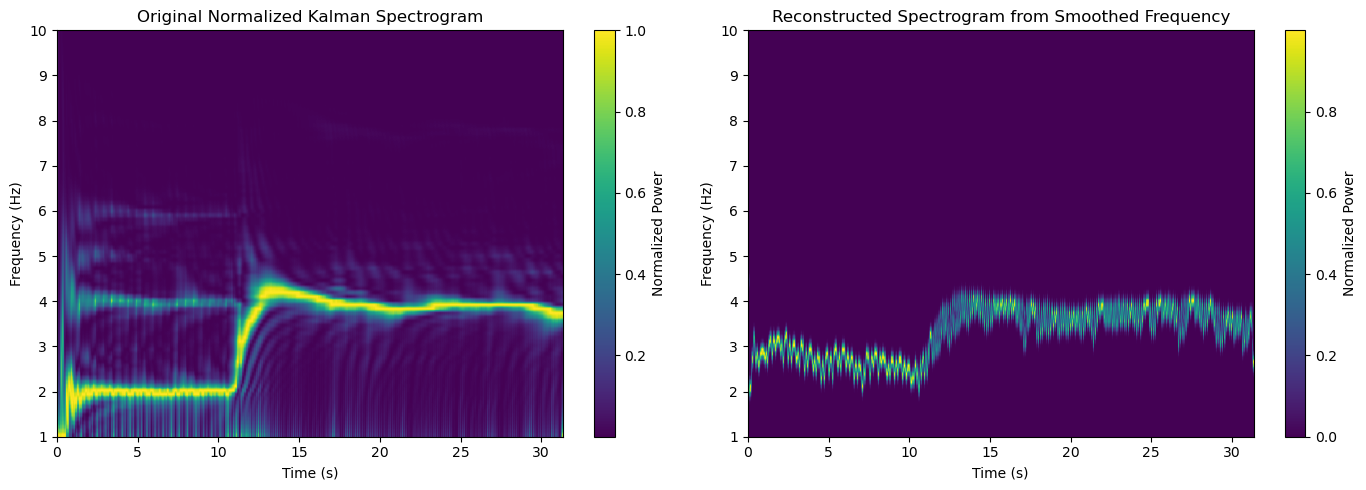

In [181]:
# Reconstruct and plot spectrogram from smoothed mean frequencies
mean_freqs, _ = compute_frequency_uncertainty(spec, freq_grid)
recon_spec = reconstruct_spectrogram_from_estimates(mean_freqs, freq_grid, sigma=0.1)

# Compute time axis and normalize both spectrograms
t = np.arange(spec.shape[1]) / fs
spec_norm = spec / (np.max(spec, axis=0, keepdims=True) + 1e-10)
recon_spec_norm = recon_spec / (np.max(recon_spec, axis=0, keepdims=True) + 1e-10)

# Create figure with two subplots
plt.figure(figsize=(14, 5))

# Subplot 1: Original normalized spectrogram
plt.subplot(1, 2, 1)
plt.imshow(spec_norm, extent=[t[0], t[-1], freq_grid[0], freq_grid[-1]],
           aspect='auto', origin='lower', cmap='viridis')
plt.title("Original Normalized Kalman Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Normalized Power")

# Subplot 2: Reconstructed normalized spectrogram
plt.subplot(1, 2, 2)
plt.imshow(recon_spec_norm, extent=[t[0], t[-1], freq_grid[0], freq_grid[-1]],
           aspect='auto', origin='lower', cmap='viridis')
plt.title("Reconstructed Spectrogram from Smoothed Frequency")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Normalized Power")

plt.tight_layout()
plt.show()

Tremor Signal Reconstruction from Kalman Filter Bank

To evaluate how well the estimated frequencies and amplitudes capture the original tremor signal, we reconstruct the signal from the Kalman filter bank output. The reconstruction uses the estimated sinusoidal components from each frequency bin and sums them to form an approximation of the original signal.

This reconstructed signal is then compared against the original filtered tremor signal to assess:
	•	Accuracy of frequency and amplitude tracking
	•	How well the Kalman model represents time-varying tremor dynamics

Observations from the Plots
	•	The first 10 seconds of the recording (during the ~2 Hz tremor phase) show a larger mismatch between the original signal and the reconstructed signal.
	•	This suggests that the Kalman filter has more difficulty reconstructing low-frequency components, possibly due to:
	•	Higher variability or drift in the low-frequency oscillation
	•	Broader harmonics or waveform non-sinusoidality
	•	Higher uncertainty in the frequency estimate
	•	After the tremor frequency increases to ~4 Hz (later in the recording), the reconstructed signal closely tracks the ground truth.
	•	The higher-frequency oscillation is likely more regular and sinusoidal, making it easier for the Kalman filter bank to model accurately.
	•	This is consistent with earlier observations of lower uncertainty and higher harmonic score stability in this phase.

Interpretation

The difference in reconstruction quality highlights how tremor waveform shape and stability impact time-frequency estimation:
	•	Low-frequency tremors may be more prone to distortion, asymmetry, or transient components, leading to less accurate modeling.
	•	High-frequency tremors are often cleaner and more periodic, allowing for better phase and amplitude tracking by harmonic and Kalman-based methods.

In [182]:
# plot with kalman and true sprectrogram instead

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BFD802900B5: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


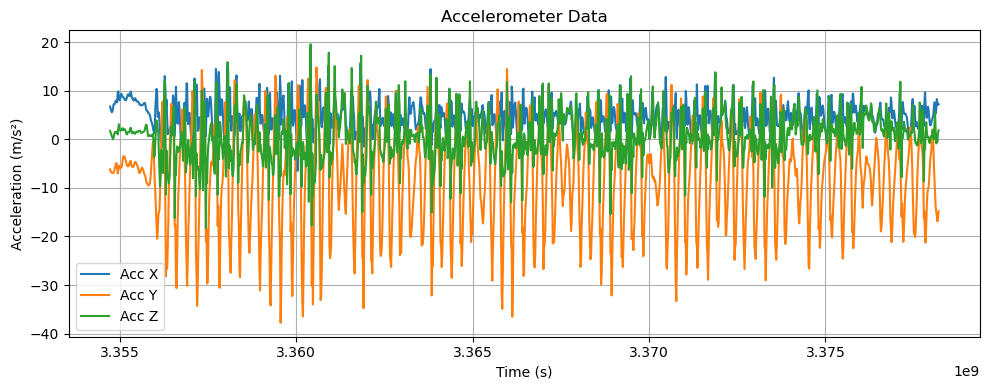

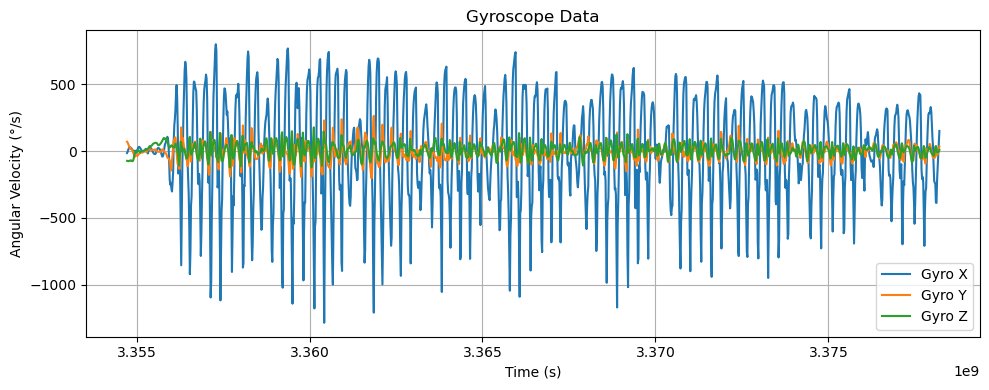

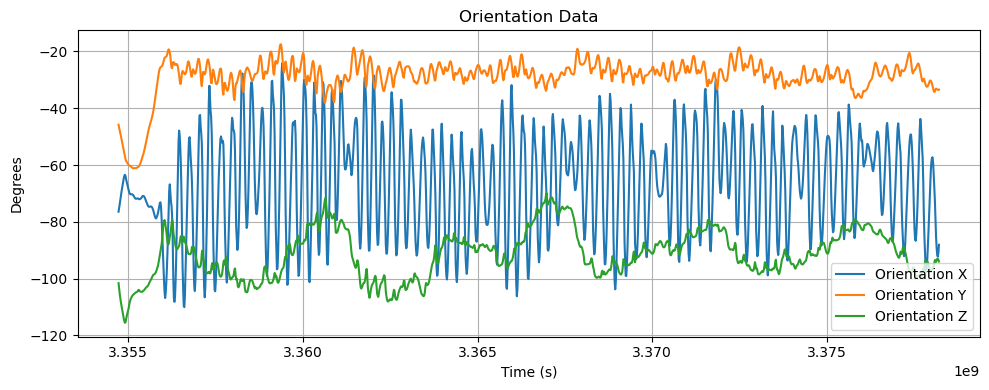

In [183]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial2/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[6])
    print(f"Keys in {imus[6]}:", keys)

acc, gyro, orient, time = load_imu_data(path, imus[6])
plot_imu_data(acc, gyro, orient, time)


Voluntary vs Tremor Movement in Orientation Data

In this section, we analyze the orientation data (Roll, Pitch, and Yaw angles) to separate voluntary and tremor-induced components of movement. This is done by applying a bandpass filter:
	•	Voluntary movement is expected to occur at lower frequencies (0.1–2 Hz).
	•	Tremor movement typically occurs at higher frequencies (3–8 Hz).

We filter the orientation signal into these two bands for each of the three axes (Roll, Pitch, Yaw), and plots them in subplots.


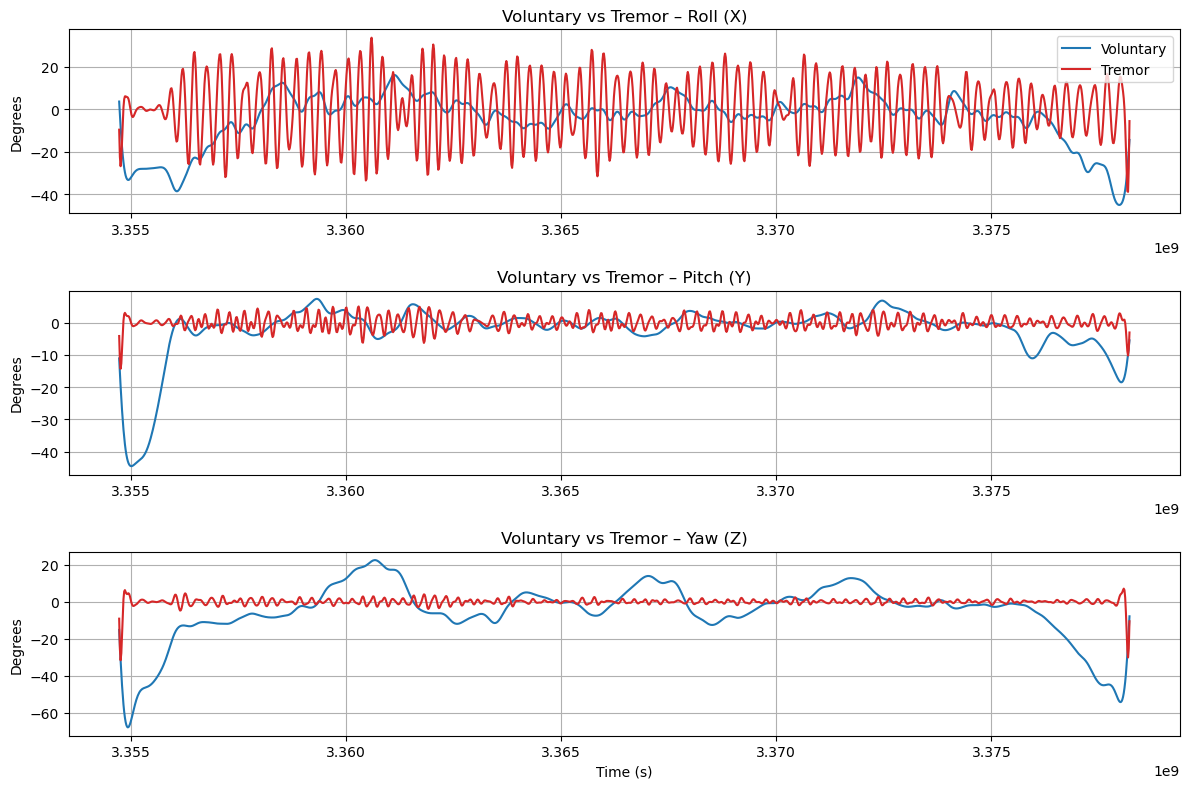

In [184]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter(data, lowcut, highcut, fs, order=3):
    """Apply a bandpass filter along axis=0 (time axis), robust to short inputs."""
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    # Use method='gust' for short signals
    return filtfilt(b, a, data, axis=0, method='gust')

def plot_orientation_voluntary_tremor(orient, time, fs=60):
    """
    Plot voluntary and tremor components of orientation (Roll, Pitch, Yaw) as subplots.
    
    Parameters:
    - orient: np.ndarray of shape (N, 3), orientation data (not transposed)
    - time: np.ndarray of shape (N,), time vector
    - fs: sampling frequency
    """
    if orient.shape[0] < 30:
        raise ValueError("Orientation signal too short for filtering.")

    # Apply bandpass filters for voluntary and tremor movement
    voluntary_orient = bandpass_filter(orient, lowcut=0.1, highcut=2, fs=fs)
    tremor_orient = bandpass_filter(orient, lowcut=3, highcut=8, fs=fs)

    axes_labels = ['Roll (X)', 'Pitch (Y)', 'Yaw (Z)']
    
    plt.figure(figsize=(12, 8))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(time, voluntary_orient[:, i], label='Voluntary', color='tab:blue')
        plt.plot(time, tremor_orient[:, i], label='Tremor', color='tab:red')
        plt.ylabel("Degrees")
        plt.title(f"Voluntary vs Tremor – {axes_labels[i]}")
        plt.grid(True)
        if i == 0:
            plt.legend(loc='upper right')
        if i == 2:
            plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

plot_orientation_voluntary_tremor(orient.T, time, fs=60)


Plot Interpretation

Each subplot shows the filtered orientation signal over time:
	•	Blue line: Voluntary movement component (low frequency).
	•	Red line: Tremor component (high frequency).

Observations:
	•	Roll (X-axis): A strong, periodic tremor signal is visible (red), overlaid on top of slow voluntary modulations (blue). This suggests tremor is most pronounced in this axis.
	•	Pitch (Y-axis): Voluntary movement dominates, with tremor visible but less pronounced compared to Roll.
	•	Yaw (Z-axis): Clear voluntary motion with broad swings, while tremor appears much weaker or nearly absent.

⸻

Goal of this Analysis

By separating voluntary and tremor movements:
	•	We can better understand which axes are affected by tremor.
	•	This helps in designing tremor suppression systems (e.g., filters, assistive devices) by targeting the dominant tremor direction.
	•	We also gain insight into user intent vs involuntary motion, aiding in control or classification tasks.